In [26]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm

random_state = 123_456
np.random.seed(random_state)

sns.set()
plt.rc('figure',figsize=(16,12))
plt.rc('font',size=13)

In [27]:
df = pd.read_csv('fuel-prices/all_years_combined.csv', index_col='date', dtype={'price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.size, freq='D'), inplace=True, verify_integrity=True)

In [28]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(df.price, order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=False)
res = mod.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                 1095
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -5348.128
Date:                            Thu, 05 Mar 2020   AIC                          10704.257
Time:                                    15:45:38   BIC                          10724.203
Sample:                                01-01-2017   HQIC                         10711.808
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0377      0.024     -1.549      0.121      -0.085       0.010
ar.L2          0.1050      0.026      4.029      0.000       0.054       0.156
ar.S.L12      -0.6198      0.019    -33.279      0.000      -0.656      -0.583
sigma2      1144.1103     35.200     32.503      0.000    1075.119    1213.102
===================================================================================
Ljung-Box (Q):                      266.57   Jarque-Bera (JB):               284.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.60
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# res.forecast(steps=7)

In [30]:
# Dynamic predictions
# predict_dy = res.get_prediction(dynamic='2019-12-30').predicted_mean
# predict_dy

In [31]:
# one-step-ahead in-sample predictions for the entire sample
y_hat = res.get_prediction().predicted_mean
y_hat.iloc[0] = y_hat.iloc[1]
y_hat

2017-01-01    1416.943943
2017-01-02    1416.943943
2017-01-03    1436.140462
2017-01-04    1408.994746
2017-01-05    1541.998971
                 ...     
2019-12-27    1582.118295
2019-12-28    1594.514590
2019-12-29    1579.436303
2019-12-30    1592.672652
2019-12-31    1587.534606
Freq: D, Length: 1095, dtype: float64

In [32]:
df

price
2017-01-01   1417
2017-01-02   1436
2017-01-03   1409
2017-01-04   1542
2017-01-05   1582
...           ...
2019-12-27   1608
2019-12-28   1589
2019-12-29   1579
2019-12-30   1602
2019-12-31   1609

[1095 rows x 1 columns]

In [33]:
def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
    it = np.nditer(y_test, flags=['f_index'])
    non_error_count = 0
    
    while not it.finished:
        upper_limit = it[0] * (1 + tolerance_percentage / 100)
        lower_limit = it[0] - (upper_limit - it[0])
        non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
        it.iternext()
        
    return non_error_count / y_test.size

In [36]:
# df.plot()
# y_hat.plot()
# plt.show()
# y_hat[0]
# y_hat.where(y_hat > 1415)
# y_hat.describe()
drop_id = y_hat.idxmax()
y_hat.drop(drop_id, inplace=True)
df.drop(drop_id, inplace=True)

In [38]:
error_tolerance_percentage = 2.5
get_relative_accuracy(df.price.values, y_hat.values, error_tolerance_percentage)

0.8080438756855576

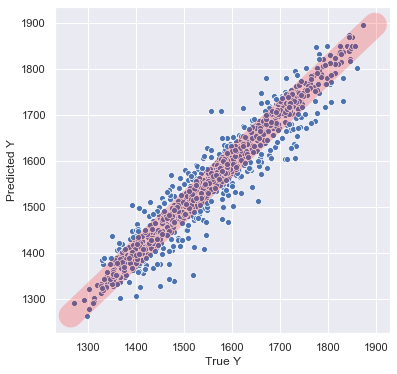

In [37]:
line_x_y = [math.floor(min(df.price.values.min(),y_hat.values.min())), 
            math.ceil(max(df.price.values.max(),y_hat.values.max()))]
_ = plt.figure(figsize = (6, 6))
_ = plt.plot(line_x_y, line_x_y, linewidth=24, alpha=0.2, color='red')
_ = sns.scatterplot(df.price.values.reshape(1,-1)[0], y_hat.values)
_ = plt.ylabel('Predicted Y')
_ = plt.xlabel('True Y')
plt.show()